dfdfd

In [603]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor, Pool, cv
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet

from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator, RegressorMixin

In [604]:
# df = pd.read_csv("/Users/tomilovdima/avito_parcer/avito_massive_dump.csv")
# df = pd.read_csv("/Users/tomilovdima/avito_flats_ml_project/avito_dump_28 — копия 2.csv")

In [605]:
# Загрузка CSV
df = pd.read_csv("/Users/tomilovdima/avito_flats_ml_project/data/raw/processed/avito_merged_clean.csv")

print(df.shape)

(5815, 4)


In [606]:
cols_to_check = df.drop(columns=['Ссылка']).columns
dupes = df[df.duplicated(subset=cols_to_check, keep=False)]
print(len(dupes))

0


In [607]:
df = df.drop_duplicates(subset=cols_to_check, keep='first')

In [608]:
def extract_refined_features(text):
    if not isinstance(text, str):
        return pd.Series({})

    res = {}

    # --- МЕТРО ---
    metro_with_time = re.findall(r"([А-Я][а-яё]+(?:\s+[А-Яа-яё]+)?)\s*\d+(?:–\d+)?\s*мин\.", text)
    if metro_with_time:
        clean_metros = sorted(list(set(m.strip() for m in metro_with_time)))
        res['все_метро'] = ", ".join(clean_metros)
        first_time = re.search(r"(\d+)(?:–\d+)?\s*мин\.", text)
        res['время_до_ближайшего_мин'] = first_time.group(1) if first_time else None
    else:
        res['все_метро'] = "Н/Д"
        res['время_до_ближайшего_мин'] = "Н/Д"

    # --- О КВАРТИРЕ ---
    res['комнат'] = re.search(r"Количество комнат:\s*(.*?)(?=\s*Общая площадь|$)", text)
    res['площадь_общая'] = re.search(r"Общая площадь:\s*([\d.]+)", text)
    res['площадь_кухни'] = re.search(r"Площадь кухни:\s*([\d.]+)", text)
    res['площадь_жилая'] = re.search(r"Жилая площадь:\s*([\d.]+)", text)

    floor_match = re.search(r"Этаж:\s*(\d+)\s*из\s*(\d+)", text)
    res['этаж'] = floor_match.group(1) if floor_match else "Н/Д"
    res['этажность_дома'] = floor_match.group(2) if floor_match else "Н/Д"

    res['тип_комнат'] = re.search(r"Тип комнат:\s*(.*?)(?=\s*(?:Высота|Санузел|Окна|Балкон|$))", text)
    res['высота_потолков'] = re.search(r"Высота потолков:\s*([\d.]+)", text)
    res['санузел'] = re.search(r"Санузел:\s*(.*?)(?=\s*(?:Окна|Ремонт|Техника|$))", text)
    res['окна'] = re.search(r"Окна:\s*(.*?)(?=\s*(?:Ремонт|Способ|Тёплый|$))", text)
    res['ремонт'] = re.search(r"Ремонт:\s*(.*?)(?=\s*(?:Тёплый|Техника|Способ|Вид|Мебель|$))", text)

    # --- МЕБЕЛЬ ---
    match = re.search(r"Мебель:\s*(.+?)(?=\s*$|\n|$)", text, flags=re.IGNORECASE)
    if match:
        furniture_list = [i.strip() for i in match.group(1).split(",")]
    else:
        furniture_list = []
    res['furniture_list'] = furniture_list

    # --- СПОСОБ ПРОДАЖИ ---
    match = re.search(r"Способ продажи[:\s]*([^\n\.]+)", text, flags=re.IGNORECASE)
    if match:
        res['способ_продажи'] = match.group(1).strip()
    else:
        # иногда встречается "Прямая продажа" или "Возможна ипотека" без явного "способ продажи"
        alt_match = re.search(r"(Прямая продажа|Возможна ипотека|Только наличный расчёт)", text, flags=re.IGNORECASE)
        if alt_match:
            res['способ_продажи'] = alt_match.group(1).strip()
        else:
            res['способ_продажи'] = "Н/Д"


    res['вид_сделки'] = re.search(r"Вид сделки:\s*(.*?)(?=\s*(?:Рыночная|Оценка|Проверка|$))", text)

    # --- О ДОМЕ ---
    res['тип_дома'] = re.search(r"Тип дома:\s*([\w-]+)", text)
    res['год_постройки'] = re.search(r"Год постройки:\s*(\d{4})", text)
    res['в_доме'] = re.search(r"В доме:\s*(.*?)(?=\s*(?:Двор|Парковка|Узнать|$))", text)
    res['двор'] = re.search(r"Двор:\s*(.*?)(?=\s*(?:Парковка|Узнать|В доме|$))", text)
    res['парковка'] = re.search(r"Парковка:\s*(.*?)(?=\s*(?:Рассчитайте|Узнать|О доме|$))", text)
    res['лифт_пасс'] = re.search(r"Пассажирский лифт:\s*(\d+)", text)
    res['лифт_груз'] = re.search(r"Грузовой лифт:\s*(\d+)", text)

    # --- Чистка объектов Match ---
    for key in res:
        if hasattr(res[key], 'group') and res[key] is not None:
            val = res[key].group(1).strip()
            res[key] = val
        elif res[key] is None:
            res[key] = "Н/Д"

    return pd.Series(res)



# --- ПРИМЕНЕНИЕ ---

# 1. Генерируем расширенные признаки
new_features = df['Все_Данные'].apply(extract_refined_features)

df_final = pd.concat([df[['Название', 'Цена', 'Ссылка']], new_features], axis=1)

num_cols = [
    "Цена", "время_до_ближайшего_мин", "комнат", "площадь_общая", 
    "площадь_кухни", "площадь_жилая", "этаж", "этажность_дома",
    "высота_потолков", "год_постройки", "лифт_пасс", "лифт_груз"
]

for col in num_cols:
    df_final[col] = pd.to_numeric(df_final[col], errors='coerce')


# Посмотрим на результат
df_final.head(2)

,Название,Цена,Ссылка,все_метро,время_до_ближайшего_мин,комнат,площадь_общая,площадь_кухни,площадь_жилая,этаж,...,furniture_list,способ_продажи,вид_сделки,тип_дома,год_постройки,в_доме,двор,парковка,лифт_пасс,лифт_груз
0,"Апартаменты-студия, 10 м², 3/5 эт.",3300000,https://www.avito.ru/sankt-peterburg/kvartiry/...,"Ладожская, Новочеркасская",6.0,NaN,10.0,NaN,5.0,3,...,[],"свободная Расположение Санкт-Петербург, Таллин...",Н/Д,кирпичный,1958.0,Н/Д,Н/Д,Н/Д,NaN,NaN
1,"Квартира-студия, 24,4 м², 4/5 эт.",5850057,https://www.avito.ru/sankt-peterburg/kvartiry/...,Н/Д,NaN,NaN,24.4,NaN,NaN,4,...,[],Н/Д,Н/Д,панельный,NaN,Н/Д,Н/Д,Н/Д,NaN,NaN


In [609]:
def extract_furniture(f_list):
    if not f_list or f_list == []:
        return pd.Series({
            "кухня": 0,
            "спальные места": 0,
            "шкаф/хранение": 0,
            "техника": 0,
            "диван/кровать": 0
        })

    # Если это список с одним большим текстом — объединим в строку
    text = " ".join(f_list) if isinstance(f_list, list) else str(f_list)
    text = text.lower()

    return pd.Series({
        "кухня": int("кухня" in text),
        "спальные места": int("спальные места" in text),
        "шкаф/хранение": int("хранение" in text or "шкаф" in text),
        "техника": int("техника" in text or "холодильник" in text or "посудомоечная" in text or "стиральная" in text),
        "диван/кровать": int("диван" in text or "кровать" in text)
    })

# Применяем к train/test
# furn_train = df_train["furniture_list"].apply(extract_furniture)
# df_train = pd.concat([df_train.drop(columns="furniture_list"), furn_train], axis=1)

# furn_test = df_test["furniture_list"].apply(extract_furniture)
# df_test = pd.concat([df_test.drop(columns="furniture_list"), furn_test], axis=1)

furn = df_final["furniture_list"].apply(extract_furniture)
df_final = pd.concat([df_final.drop(columns="furniture_list"), furn], axis=1)



In [610]:
df_final.shape

(5815, 30)

добавляю признак (апартаменты) и количество комнат в студиях (0.7)

In [611]:
def parse_title(title):
    title = str(title).lower()

    # апартаменты
    is_apartment = int("апартамент" in title)

    # комнаты
    if "студия" in title or "студии" in title:
        rooms = 0.7
    else:
        match = re.search(r"(\d+)\s*-\s*к", title)
        rooms = int(match.group(1)) if match else np.nan

    return pd.Series({
        "rooms_from_title": rooms,
        "is_apartment": is_apartment
    })
title_features = df_final["Название"].apply(parse_title)
df_final = pd.concat([df_final, title_features], axis=1)

там где регулярки не достали колчество комнат извлекаем их из названия объявления. потом удаляю вспомогательный признак (комнаты из названия)

In [612]:
df_final["комнат"] = pd.to_numeric(df_final["комнат"], errors="coerce")

mask = df_final["комнат"].isna()
df_final.loc[mask, "комнат"] = df_final.loc[mask, "rooms_from_title"]
df_final = df_final.drop(columns="rooms_from_title")

In [614]:
df_final = df_final.replace(["Н/Д", "Не указано"], np.nan)
def miss_values(data):
    missing_count = data.isna().sum()
    missing_percent = (missing_count / data.shape[0]) * 100
    
    report = pd.DataFrame({
            "Пропусков": missing_count,
            "%": missing_percent.round(2)
    })
    return report
miss_values(df_final)

,Пропусков,%
Название,0,0.00
Цена,0,0.00
Ссылка,0,0.00
все_метро,961,16.53
время_до_ближайшего_мин,961,16.53
комнат,0,0.00
площадь_общая,0,0.00
площадь_кухни,1473,25.33
площадь_жилая,890,15.31
этаж,0,0.00


<Axes: >

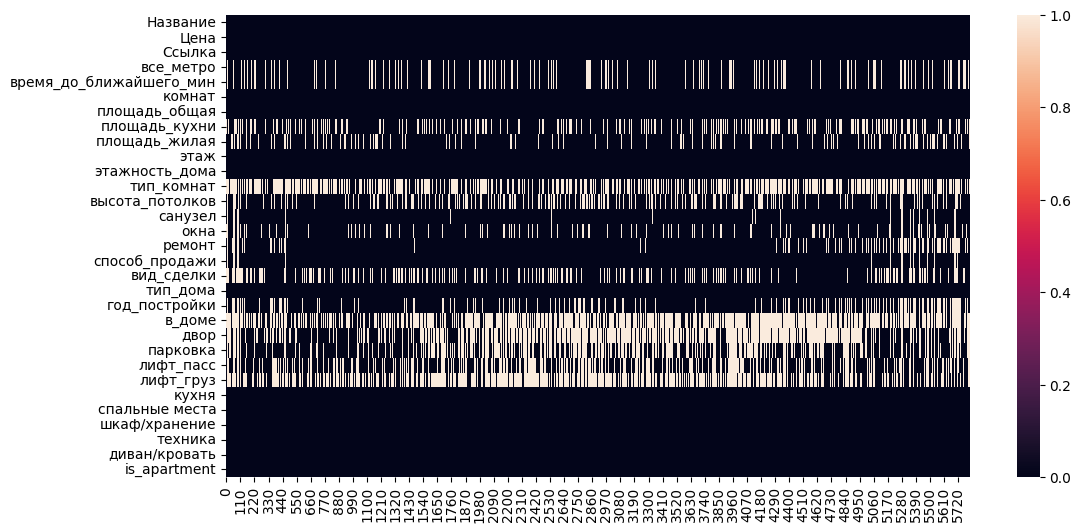

In [615]:
plt.figure(figsize=(12, 6))
sns.heatmap(df_final.isna().T)

**кратенький план на работу с пропусками:**
- все метро, время до ближ. метро: мы видим, что где пропуск в "время до близжайшего метро" там же и пропуск в колонке "все метро", значит, что рядом с квартирой просто нету метро, можем заменить "все метро" на нули и "время до близжайшего метро" на 60 мин
- площадь кухни, жилая: если это студия, площадь кухни = 0, если не указана жилая площадь и площ кухни, заполню их медианой доли
- лифты: если не указаны, то 0, тк лифта значит нету
- парковка: если не указана, значит нету
- в доме: если нету, то 0, тк значит нету фишек у дома

In [616]:
df_final["все_метро"] = df_final["все_метро"].fillna(0) #ставим 0 метро, если рядом нету метро
df_final["время_до_ближайшего_мин"] = df_final["время_до_ближайшего_мин"].fillna(60) #если рядом нету метро, ставим время до метро просто большое значение
df_final[["лифт_пасс", "лифт_груз"]] = df_final[["лифт_пасс", "лифт_груз"]].fillna(0) #если пропуск в лифтах, их нету, ставим 0
df_final["парковка"] = df_final["парковка"].fillna(0) #если пропуск, то парковки нету, ставим 0

In [617]:
df_train, df_test = train_test_split(df_final, test_size=0.2, random_state=42, shuffle=True)

**заполняю пропуски в площади кухни и жилой площади**

In [618]:
#если это студия (0.7 комнат) и площадь кухни неизвестна, ставим ее равную нулю (тк у студий не считается площадь кухни)
df_train.loc[(df_train['комнат'] == 0.7) & (df_train['площадь_кухни'].isna()), 'площадь_кухни'] = 0
df_test.loc[(df_test['комнат'] == 0.7) & (df_test['площадь_кухни'].isna()), 'площадь_кухни'] = 0

# считаем отношение площади кухни к общей площади квартиры
train_ratios = df_train.copy()
train_ratios["k_ratio"] = train_ratios["площадь_кухни"] / train_ratios["площадь_общая"]

#сколько процентов от общей площади обычно занимает кухня в 1к, 2к, 3к,... квартирах
#группируем по числу комнат, берем медианную долю кухни, превращаем в словарь получаем типо: 1: 10, 2: 20, 3: 50, ...
kitchen_ratio_map = train_ratios.groupby('комнат')['k_ratio'].median().to_dict()
global_k_ratio = train_ratios['k_ratio'].median() #глабальная медиана, если вдруг, для какойнибудь квартиры нету данных (берем просто медианную площадь кухни по датасету)

#заполняем пропуски в кухне:
def fill_kitchen(row, ratio_map, global_ratio):
    if pd.isna(row["площадь_кухни"]): #проверяем пропущена ли кухня
        ratio = ratio_map.get(row['комнат'], global_ratio) #берем медианную долю по комнатам, или если нету, медианную долю по датасету
        return row['площадь_общая'] * ratio
    return row['площадь_кухни'] #если пропуска нету, оставляем как есть
#применяем функцию к каждой строке, передаем в аргументах словарь коэффициентов и глобальную медианную долю
df_train['площадь_кухни'] = df_train.apply(fill_kitchen, axis=1, args=(kitchen_ratio_map, global_k_ratio)) 
df_test['площадь_кухни'] = df_test.apply(fill_kitchen, axis=1, args=(kitchen_ratio_map, global_k_ratio))

In [619]:
# Создаем столбец с долей жилой площади
train_ratios['l_ratio'] = train_ratios['площадь_жилая'] / train_ratios['площадь_общая']

# Медианная доля жилой площади по комнатам
living_ratio_map = train_ratios.groupby('комнат')['l_ratio'].median().to_dict()

# Глобальная медиана
global_l_ratio = train_ratios['l_ratio'].median()

# Функция для заполнения жилой площади
def fill_living(row, ratio_map, global_ratio):
    if pd.isna(row["площадь_жилая"]):
        ratio = ratio_map.get(row['комнат'], global_ratio)
        return row['площадь_общая'] * ratio
    return row['площадь_жилая']

# Заполняем пропуски в train и test
df_train['площадь_жилая'] = df_train.apply(fill_living, axis=1, args=(living_ratio_map, global_l_ratio))
df_test['площадь_жилая'] = df_test.apply(fill_living, axis=1, args=(living_ratio_map, global_l_ratio))

проверяю признак "вид сделки", тут 40 процентов пропусков, остальные "возможна ипотека", просто заменю его на 0 если пропуск и 1 если "возможна ипотека"

In [620]:
def check_deal(x):
    if pd.isna(x):
        return np.nan
    elif "возможна ипотека" in x:
        return True
    else:
        return False
check = df_final['вид_сделки'].apply(check_deal)
check.unique()

array([nan, True, False], dtype=object)

In [621]:
#(в единственном False какойто мусор, так что этот признак просто говорит о возможности взять эту квартиру в ипотеку)
df_train["вид_сделки"] = df_train["вид_сделки"].apply(lambda x: 1 if isinstance(x, str) and "возможна ипотека" in x.lower() else 0)
df_test["вид_сделки"] = df_test["вид_сделки"].apply(lambda x: 1 if isinstance(x, str) and "возможна ипотека" in x.lower() else 0)

заполняю пропуски и кодирую признак "тип_комнат"

In [622]:
df_final["тип_комнат"].unique()

array([nan, 'изолированные', 'изолированные, смежные', 'смежные',
       'изолированные Отделка: предчистовая Расположение ул. Шостаковича, уч. 1 Проспект Просвещения11–15 мин. Парнас21–30 мин. Озеркиот 31 мин. © Яндекс Условия использования Описание Hoвый дoм oт RBI у мeтрo «Проспект Пpоcвещeния» на улице Шостаковичa. Aвтopы пpoекта вдохновлялись творчecтвом Дмитрия Шостаковича и кapeльcкой приpодой. Двa паpкa нa тepритopии, 4 дeтскиe плoщадки c экoлогичным oбoрудoвaнием, параднoe лобби c лаунжeм, кoворкингoм и музыкальнoй студиeй. И интерактивный арт-объект “Гром-камень”, издающий звуки природы, от творческой студии Sрlасеs. В доме продаётся по переуступке Двухкомнатная квартира площадью 51.5 м² на 14 этаже. Всего в новом доме RВI «Струны» у метро «Проспект Просвещения» 1 137 квартир (в двух очередях), от 110 до 167 квартир в каждом корпусе. Площадь квартир — от 28 до 124 квадратных метров. Среди них и классические, и европланировки с просторными кухнями-гостиными. Квартиры продаются

In [623]:
def encode_room_type(val):
    val = str(val).lower()
    return pd.Series({
        "изолированные комнаты": int("изолированные" in val),
        "смежные комнаты": int("смежные" in val),
        "тип_комнаты_неизвестен": int(pd.isna(val))
    })
room_type_coding_train = df_train["тип_комнат"].apply(encode_room_type)
df_train = pd.concat([df_train.drop(columns="тип_комнат"), room_type_coding_train], axis=1)
room_type_coding_test = df_test["тип_комнат"].apply(encode_room_type)
df_test = pd.concat([df_test.drop(columns="тип_комнат"), room_type_coding_test], axis=1)

In [624]:
df_final["высота_потолков"].unique()

array([ 3.7,  2.8,  2.6,  2.9,  2.7,  2.5,  nan,  3.4,  3. ,  3.3,  3.6,
        3.8,  5.1,  4.6,  3.2,  3.1,  1.7,  3.5,  4.2,  2.4,  2. ,  5. ,
       25. ,  4. ,  4.1,  1.8, 35. ,  4.7, 28. ,  5.9,  3.9,  4.4,  6.5,
       10.2, 27. ,  5.5,  4.9])

In [625]:
#считаем медиану высоты потолков, пропуски просто ей заполним. считаем на треине, применяем на треине и тесте для избежания утечки данных
heigh_med = df_train["высота_потолков"].median()
df_train["высота_потолков"] = df_train["высота_потолков"].fillna(heigh_med)
df_test["высота_потолков"] = df_test["высота_потолков"].fillna(heigh_med)

- кодирую и заполняю тип занузла. регулярка не очень хорошо его подцепила, так что там много мусора в строках, но в целом видно, что он бывает только совмещенным или раздельным или пропуск
- кодирую по прежнему принципу

In [626]:
def toilet_type(val):
    val = str(val).lower()
    return pd.Series({
        "совмещенный санузел": int("совмещенный" in val),
        "раздельный санузел": int("раздельный" in val),
        "неизвестный санузел": int(pd.isna(val))
    })
toilet_coding_train = df_train["санузел"].apply(toilet_type)
df_train = pd.concat([df_train.drop(columns="санузел"), toilet_coding_train], axis=1)
toilet_type_coding_test = df_test["санузел"].apply(toilet_type)
df_test = pd.concat([df_test.drop(columns="санузел"), toilet_type_coding_test], axis=1)

In [627]:
df_train["окна"].unique()

array(['во двор, на улицу, на солнечную сторону', 'на улицу', nan,
       'во двор, на улицу Отделка: предчистовая Вид сделки: возможна ипотека Расположение наб. Октябрьская, д. 42 Улица Дыбенко21–30 мин. Елизаровскаяот 31 мин. Ломоносовскаяот 31 мин. © Яндекс Условия использования Описание Пpодаётся 1-кoмнатная квартира в ЖК «Цивилизaция на Hевe» нa 6 этаже. Общaя плoщадь cocтaвляeт 38.85 кв. м. Квартира с whitе bоx oтделкой. Жилой комплекс «Цивилизация нa Heвe» раcполагaетcя пo aдpeсу Caнкт-Пeтеpбуpг, Нeвский. «Цивилизация нa Hевe» – видoвые домa бизнеc-клaссa, paспoлoженные вдoль нaбережной Невы, всего в 7 км от исторического центра. Жилой комплекс идеально выражает особый дух, свойственный знаменитым просторным кварталам постройки сталинской эпохи в Москве и на Московском проспекте в Петербурге. Расположение: • 15 мин на авто до Невского проспекта; • 15 мин на авто до Московского вокзала; • 5 мин на авто до станции метро «Улица Дыбенко»; • 14 мин (7 км) до КАД. Уникальный дизайн вх

парсер (регулярки) и тут тоже нахватали мусора, но по сути, у нас есть варианты: на улицу, во двор, на солнечную сторону, и иногда они комбинируются, причем вероятно в случайном порядке, так что я просто закодирую их как делал раньше

In [628]:
def encode_window(val):
    val = str(val).lower()
    return pd.Series({
        "окна во двор": int("во двор" in val),
        "окна на улицу": int("на улицу" in val),
        "окна на солнечную сторону": int("на солнечную сторону" in val),
        "окна неизвестны": int(pd.isna(val))
    })
window_coding_train = df_train["окна"].apply(encode_window)
df_train = pd.concat([df_train.drop(columns="окна"), window_coding_train], axis=1)
window_coding_test = df_test["окна"].apply(encode_window)
df_test = pd.concat([df_test.drop(columns="окна"), window_coding_test], axis=1)


In [ ]:
# 1. Бины по общей площади (ФИКСИРОВАННЫЕ)
BINS = [0, 30, 45, 60, 75, 90, 120, 150, 200, np.inf]
LABELS = range(len(BINS) - 1)

# 2. Создаём бины ОДИНАКОВО для train и test
df_train['area_bin'] = pd.cut(
    df_train['площадь_общая'],
    bins=BINS,
    labels=LABELS
)

df_test['area_bin'] = pd.cut(
    df_test['площадь_общая'],
    bins=BINS,
    labels=LABELS
)

# 3. Считаем медиану комнат ТОЛЬКО по train
median_rooms_per_bin = (
    df_train
    .groupby('area_bin')['комнат']
    .median()
)

# 4. Заполняем пропуски в train
mask_train = df_train['комнат'].isna()
df_train.loc[mask_train, 'комнат'] = (
    df_train.loc[mask_train, 'area_bin']
    .map(median_rooms_per_bin)
)

# 5. Заполняем пропуски в test
mask_test = df_test['комнат'].isna()
df_test.loc[mask_test, 'комнат'] = (
    df_test.loc[mask_test, 'area_bin']
    .map(median_rooms_per_bin)
)

# 6. Фоллбек: если бин был в test, но отсутствовал в train
global_median_rooms = df_train['комнат'].median()

df_train['комнат'] = df_train['комнат'].fillna(global_median_rooms)
df_test['комнат']  = df_test['комнат'].fillna(global_median_rooms)

# 7. Удаляем служебный столбец
df_train.drop(columns='area_bin', inplace=True)
df_test.drop(columns='area_bin', inplace=True)

In [629]:
# cols_to_check = df_train.drop(columns=['Ссылка', 'furniture_list']).columns
# dupes = df_train[df_train.duplicated(subset=cols_to_check, keep=False)]
# print(len(dupes))

в ремонт тоже попал мусор, убираю его

In [630]:
#извлекаем категорию ремонта
def extract_repair(text):
    text = str(text)
    text = text.lower()
    if "дизайнер" in text:
        return "дизайнерский"
    if "евро" in text:
        return "евро"
    if "космет" in text:
        return "косметический"
    if "требует ремонта" in text:
        return "требует ремонта"

    return "не указано"

df_train["ремонт"] = df_train["ремонт"].apply(extract_repair)
df_test["ремонт"] = df_test["ремонт"].apply(extract_repair)
df_train["ремонт"].unique()

array(['косметический', 'не указано', 'евро', 'дизайнерский',
       'требует ремонта'], dtype=object)

In [631]:
count = df_final['способ_продажи'].str.contains('свободная', case=False, na=False).sum()
count, df_final.shape[0]

(np.int64(4602), 5815)

In [632]:
df_final[~df_final['способ_продажи'].str.contains('свободная', case=False, na=False)]["способ_продажи"].head()

1                                                  NaN
3                                     возможна ипотека
6                                     возможна ипотека
8    альтернативная Вид сделки: возможна ипотека Ры...
9                                                  NaN
Name: способ_продажи, dtype: object

ну короче тут видно что бывает либо свободная либо альтернативная, вытащим их и посмотрим на остальные

In [633]:
def chack_sposob(val):
    val = str(val).lower()
    if "свободная" in val:
        return "свободная"
    elif "альтернативная" in val:
        return "альтернативная"
    else:
        return val
df_train["способ_продажи"] = df_train["способ_продажи"].apply(chack_sposob)
df_train["способ_продажи"].unique()

array(['свободная', 'nan', 'возможна ипотека', 'альтернативная',
       'договор долевого участия вид сделки: возможна ипотека расположение гп новоселье, ул',
       'договор долевого участия расположение ш',
       'договор долевого участия вид сделки: возможна ипотека расположение тер',
       'договор долевого участия вид сделки: возможна ипотека расположение п',
       'переуступка вид сделки: возможна ипотека расположение ш',
       'договор долевого участия вид сделки: возможна ипотека расположение пр-т лермонтовский, стр',
       'переуступка расположение пр-т коменданский, уч',
       'переуступка вид сделки: возможна ипотека расположение ул',
       'договор долевого участия вид сделки: возможна ипотека расположение ул',
       'переуступка вид сделки: возможна ипотека расположение пр-т коломяжский, д',
       'договор долевого участия расположение г',
       'переуступка вид сделки: возможна ипотека расположение октябрьская наб',
       'переуступка расположение пр-т комендан

In [634]:
def encode_sposob(val):
    val = str(val).lower()
    return pd.Series({
        "способ_свободная": int("свободная" in val),
        "способ_альтернативная": int("альтернативная" in val),
        "способ_ипотека": int("ипотека" in val),
        "способ_переуступка": int("переуступка" in val),
        "способ_договор долевого участия": int("договор долевого участия" in val),
        "способ_неизвестно": int(pd.isna(val) or val == "nan")
    })

# Для train
sposob_coding_train = df_train["способ_продажи"].apply(encode_sposob)
df_train = pd.concat([df_train.drop(columns="способ_продажи"), sposob_coding_train], axis=1)

# Для test
sposob_coding_test = df_test["способ_продажи"].apply(encode_sposob)
df_test = pd.concat([df_test.drop(columns="способ_продажи"), sposob_coding_test], axis=1)


In [635]:
df_train["год_постройки"].unique()

array([1965., 2017.,   nan, 2020., 1906., 1972., 2024., 1909., 2018.,
       2023., 2008., 2005., 1934., 2014., 1966., 1990., 2006., 1978.,
       1904., 1899., 1936., 2022., 1984., 2021., 2015., 1902., 1872.,
       1977., 2009., 1969., 1907., 1917., 1991., 2003., 1911., 2025.,
       1961., 1985., 1999., 2019., 1993., 1987., 1857., 1877., 2013.,
       2016., 1809., 1958., 1967., 2012., 1994., 1981., 1953., 1970.,
       1973., 1879., 1983., 1982., 1996., 1863., 2011., 1830., 1885.,
       1916., 1891., 1912., 1974., 1849., 1976., 1986., 2010., 1962.,
       1903., 1901., 1846., 1905., 1989., 2004., 1988., 1908., 1998.,
       2007., 1939., 1954., 1913., 1971., 2001., 1995., 1897., 1886.,
       1959., 1881., 1873., 1980., 1839., 1957., 1968., 1975., 1956.,
       1889., 1963., 1806., 1914., 1910., 1798., 1854., 1898., 1870.,
       1931., 1894., 1960., 1858., 2002., 1874., 1882., 1964., 1860.,
       1929., 1884., 1876., 1949., 1952., 1895., 1979., 1756., 1878.,
       2000., 1951.,

год постройки заполню медианой по типу дома и этажности. это лучший вариант, тк к примеру 5 этажей + панель - хрущёвка (60–70); 9 этажей + панель - 70–80; 16–25 этажей + монолит - 2005+

In [636]:
# флаг: был ли указан год постройки
df_train["год_не_указан"] = df_train["год_постройки"].isna().astype(int)
df_test["год_не_указан"] = df_test["год_постройки"].isna().astype(int)

# считаем медианы только на train
median_type_floor = df_train.groupby(["тип_дома","этажность_дома"])["год_постройки"].median()
median_type = df_train.groupby("тип_дома")["год_постройки"].median()
median_floor = df_train.groupby("этажность_дома")["год_постройки"].median()
global_median_year = df_train["год_постройки"].median()

# train
mask = df_train["год_постройки"].isna()
df_train.loc[mask,"год_постройки"] = pd.to_numeric(
    df_train.loc[mask].set_index(["тип_дома","этажность_дома"]).index.map(median_type_floor),
    errors="coerce"
)

mask = df_train["год_постройки"].isna()
df_train.loc[mask,"год_постройки"] = pd.to_numeric(
    df_train.loc[mask,"тип_дома"].map(median_type),
    errors="coerce"
)

mask = df_train["год_постройки"].isna()
df_train.loc[mask,"год_постройки"] = pd.to_numeric(
    df_train.loc[mask,"этажность_дома"].map(median_floor),
    errors="coerce"
)

df_train["год_постройки"] = df_train["год_постройки"].fillna(global_median_year).astype("float64")

# test
mask = df_test["год_постройки"].isna()
df_test.loc[mask,"год_постройки"] = pd.to_numeric(
    df_test.loc[mask].set_index(["тип_дома","этажность_дома"]).index.map(median_type_floor),
    errors="coerce"
)

mask = df_test["год_постройки"].isna()
df_test.loc[mask,"год_постройки"] = pd.to_numeric(
    df_test.loc[mask,"тип_дома"].map(median_type),
    errors="coerce"
)

mask = df_test["год_постройки"].isna()
df_test.loc[mask,"год_постройки"] = pd.to_numeric(
    df_test.loc[mask,"этажность_дома"].map(median_floor),
    errors="coerce"
)

df_test["год_постройки"] = df_test["год_постройки"].fillna(global_median_year).astype("float64")

In [637]:
# cols_to_check = df_train.drop(columns=['Ссылка', 'furniture_list']).columns
# dupes = df_train[df_train.duplicated(subset=cols_to_check, keep=False)]
# print(len(dupes))

In [638]:
# df_train = df_train.drop_duplicates(subset=cols_to_check, keep='first')

# cols_to_check = df_test.drop(columns=['Ссылка', 'furniture_list']).columns
# dupes = df_test[df_test.duplicated(subset=cols_to_check, keep=False)]
# df_test = df_test.drop_duplicates(subset=cols_to_check, keep='first')

In [639]:
df_train["в_доме"].unique()

array(['газ', nan, 'консьерж', 'консьерж, мусоропровод', 'мусоропровод',
       'мусоропровод, газ', 'консьерж, мусоропровод, газ',
       'Магнит, кофейня, WВ, Оzоn, салон красоты, аптека. ИНФРАСТРУКТУРА: * детский сад и школа во дворе * 5 минут пешком до остановки с бесплатной маршруткой до метро Московская. * выезд на КАД - 5 минут на машине. * ТРЦ Лето, МЕТRО, ОВI, Максидом - 10 минут на машине ДОКУМЕНТЫ: * 1 взрослый собственник, документ основания - ДДУ * Готовы к быстрой сделке * Продажа в связи с переездом — квартира полностью укомплектована, по договоренности можем оставить мебель и технику! Позвоните прямо сейчас и запишитесь на просмотр! О доме 4,6 71 отзыв Тип дома: кирпичный Год постройки: 2021 Этажей в доме: 15 Пассажирский лифт: 1 Грузовой лифт: 1',
       '«Озон», «Боксберри», копицентр, «Вкусвилл», «КБ», «Улыбка радуги», 2 булочные, кофейня, зоомагазин, компьютерный клуб, салон красоты, студия маникюра. В 2 минутах «Пятерочка», «Магнит», WВ. В 5 минутах ходьбы ТЦ «Приб

In [640]:
def in_flat_encode(text):
    text = str(text).lower()
    return pd.Series({
        "в_доме_газ": int("газ" in text),
        "в_доме_мусоропровод": int("мусоропровод" in text),
        "в_доме_консьерж": int("консьерж" in text),
        "в_доме_неизвестно": int(pd.isna(text) or "nan" in text),
    })

in_flat_train_code = df_train["в_доме"].apply(in_flat_encode) 
df_train = pd.concat([df_train.drop(columns="в_доме"), in_flat_train_code], axis=1)

in_flat_test_code = df_test["в_доме"].apply(in_flat_encode) 
df_test = pd.concat([df_test.drop(columns="в_доме"), in_flat_test_code], axis=1)

In [641]:
df_train["двор"].unique()

array(['детская площадка, спортивная площадка', nan,
       'закрытая территория, детская площадка, спортивная площадка',
       'детская площадка', 'закрытая территория',
       'закрытая территория, детская площадка',
       'закрытая территория, спортивная площадка', 'спортивная площадка',
       'детская площадка, спортивная площадка. Один взрослый собственник. Никто не прописан. Без обременений. Кухня остаётся. Развитая инфраструктура: рядом магазин, школа, детский сад. Хорошая транспортная доступность: до метро можно дойти пешком, у дома автобусная остановка. О доме 4,4 5 отзывов Тип дома: кирпичный Год постройки: 1986 Этажей в доме: 8 Пассажирский лифт: 1 Грузовой лифт: 1',
       'Территория огорожена по периметру, двор закрыт для машин (концепция «двор без машин»). * Многоуровневая Безопасность: Видеонаблюдение в местах общего пользования, консьерж-служба, видеодомофоны, бесконтактный доступ в подземный паркинг. * Паркинг: Предусмотрен подземный паркинг на 174 места с интеллек

In [642]:
def in_flat_encode(text):
    text = str(text).lower()
    return pd.Series({
        "детская_площадка": int("детская площадка" in text),
        "спортивная площадка": int("спортивная площадка" in text),
        "закрытая территория": int("закрытая территория" in text),
        "двор_неизвестно": int(pd.isna(text) or "nan" in text),
    })

in_flat_train_code = df_train["двор"].apply(in_flat_encode) 
df_train = pd.concat([df_train.drop(columns="двор"), in_flat_train_code], axis=1)

in_flat_test_code = df_test["двор"].apply(in_flat_encode) 
df_test = pd.concat([df_test.drop(columns="двор"), in_flat_test_code], axis=1)

In [643]:
df_train["парковка"].unique()

array(['открытая во дворе', 0, 'наземная многоуровневая',
       'за шлагбаумом во дворе', 'подземная',
       'открытая во дворе, за шлагбаумом во дворе',
       'подземная, за шлагбаумом во дворе',
       'подземная, открытая во дворе',
       'подземная, наземная многоуровневая, открытая во дворе, за шлагбаумом во дворе',
       'подземная, открытая во дворе, за шлагбаумом во дворе',
       'наземная многоуровневая, открытая во дворе',
       'подземная, наземная многоуровневая, открытая во дворе',
       'Удобная и тихая придомовая территория — ценный бонус для автомобилистов.',
       'подземная. Количество совмещённых санузлов: 1. Количество балконов и лоджий: 0. Эта квартира станет отличным выбором для молодых специалистов, студентов, бизнес-профессионалов и инвесторов. Не упустите шанс стать владельцем комфортного жилья в одном из лучших районов Санкт-Петербурга! Позвоните нам прямо сейчас, чтобы узнать больше и записаться на просмотр. Мы гарантируем безопасную сделку и юридиче

In [644]:
def encode_parking(text):
    text = str(text).lower()
    return pd.Series({
        "парковка_подземная": int("подземная" in text),
        "парковка_открытая_во_дворе": int("открытая во дворе" in text),
        "парковка_за_шлагбаумом": int("за шлагбаумом" in text),
        "парковка_наземная_многоуровневая": int("наземная многоуровневая" in text),
        "парковка_неизвестно": int(pd.isna(text) or "nan" in text),
    })

# Применяем к train
parking_train = df_train["парковка"].apply(encode_parking)
df_train = pd.concat([df_train.drop(columns="парковка"), parking_train], axis=1)

# Применяем к test
parking_test = df_test["парковка"].apply(encode_parking)
df_test = pd.concat([df_test.drop(columns="парковка"), parking_test], axis=1)

извлекаю мебель из мусора который оставила регулярка

In [645]:
def clean_metro_name(m):
    m = m.lower()
    m = re.sub(r"от$", "", m)
    m = re.sub(r"[^а-яё\s\-]", "", m)
    return m.strip().title()


def split_metro(val):
    if val == 0 or pd.isna(val):
        return []
    return [clean_metro_name(m) for m in str(val).split(",")]

df_train["metro_list"] = df_train["все_метро"].apply(split_metro)
# df_train["metro_list"]

#считаю среднюю цену квартиры в зависимости от метро
metro_price = (
    df_train.explode("metro_list").groupby("metro_list")["Цена"].median()
)

def best_metro_price(val, price_map):
    if not val:
        return price_map.median()
    prices = [price_map.get(m) for m in val if m in price_map]
    return np.median(prices) if prices else price_map.median()

df_train["metro_price_score"] = df_train["metro_list"].apply(
    lambda x: best_metro_price(x, metro_price)
)

df_test["metro_price_score"] = df_test["все_метро"].apply(split_metro).apply(
    lambda x: best_metro_price(x, metro_price)
)
df_train = df_train.drop(columns=["все_метро", "metro_list"])
df_test = df_test.drop(columns=["все_метро"])

In [646]:
df_train["metro_price_score"] = np.log1p(df_train["metro_price_score"])
df_test["metro_price_score"] = np.log1p(df_test["metro_price_score"])

In [647]:
cols_to_check = df_train.columns.difference(['Ссылка'])
dupes = df_train[df_train.duplicated(subset=cols_to_check, keep=False)]
print(len(dupes))

3789


In [648]:
top_10_expensive = df_train.sort_values('Цена', ascending=False).head(10)
top_10_expensive

,Название,Цена,Ссылка,время_до_ближайшего_мин,комнат,площадь_общая,площадь_кухни,площадь_жилая,этаж,этажность_дома,...,детская_площадка,спортивная площадка,закрытая территория,двор_неизвестно,парковка_подземная,парковка_открытая_во_дворе,парковка_за_шлагбаумом,парковка_наземная_многоуровневая,парковка_неизвестно,metro_price_score
2248,"10 и более-к. квартира, 1000 м², 4/4 эт.",1777000000,https://www.avito.ru/sankt-peterburg/kvartiry/...,5.0,5.0,1000.0,100.0,675.0,4,4,...,0,0,0,1,0,0,0,0,0,16.436549
2175,"10 и более-к. квартира, 1000 м², 4/4 эт.",1777000000,https://www.avito.ru/sankt-peterburg/kvartiry/...,5.0,5.0,1000.0,100.0,675.0,4,4,...,0,0,0,1,0,0,0,0,0,16.436549
4706,"1-к. квартира, 140 м², 6/8 эт.",240000000,https://www.avito.ru/sankt-peterburg/kvartiry/...,11.0,1.0,140.0,53.0,25.0,6,8,...,0,0,0,1,0,0,0,0,0,17.034386
4566,"1-к. квартира, 140 м², 6/8 эт.",240000000,https://www.avito.ru/sankt-peterburg/kvartiry/...,11.0,1.0,140.0,53.0,25.0,6,8,...,0,0,0,1,0,0,0,0,0,17.034386
4660,"1-к. квартира, 140 м², 6/8 эт.",240000000,https://www.avito.ru/sankt-peterburg/kvartiry/...,11.0,1.0,140.0,53.0,25.0,6,8,...,0,0,0,1,0,0,0,0,0,17.034386
4515,"1-к. квартира, 140 м², 6/8 эт.",240000000,https://www.avito.ru/sankt-peterburg/kvartiry/...,11.0,1.0,140.0,53.0,25.0,6,8,...,0,0,0,1,0,0,0,0,0,17.034386
4642,"1-к. квартира, 140 м², 6/8 эт.",240000000,https://www.avito.ru/sankt-peterburg/kvartiry/...,11.0,1.0,140.0,53.0,25.0,6,8,...,0,0,0,1,0,0,0,0,0,17.034386
4606,"1-к. квартира, 140 м², 6/8 эт.",240000000,https://www.avito.ru/sankt-peterburg/kvartiry/...,11.0,1.0,140.0,53.0,25.0,6,8,...,0,0,0,1,0,0,0,0,0,17.034386
5313,"3-к. квартира, 137,8 м², 2/9 эт.",119000000,https://www.avito.ru/sankt-peterburg/kvartiry/...,6.0,3.0,137.8,39.3,52.8,2,9,...,1,1,1,0,1,0,0,0,0,16.432906
5325,"3-к. квартира, 137,8 м², 2/9 эт.",119000000,https://www.avito.ru/sankt-peterburg/kvartiry/...,6.0,3.0,137.8,39.3,52.8,2,9,...,1,1,1,0,1,0,0,0,0,16.432906


In [649]:
CURRENT_YEAR = 2025

df_train["возраст_дома"] = CURRENT_YEAR - df_train["год_постройки"]
df_test["возраст_дома"] = CURRENT_YEAR - df_test["год_постройки"]
df_train.drop(columns="год_постройки", inplace=True)
df_test.drop(columns="год_постройки", inplace=True)

In [650]:
#название и ссылка больше не нужны, удаляю их
df_train = df_train.drop(columns=["Название", "Ссылка"])
df_test = df_test.drop(columns=["Название", "Ссылка"])

In [ ]:
# Добавляем фичи в train и test отдельно

# Отношения площадей
df_train['кухня_доля'] = df_train['площадь_кухни'] / df_train['площадь_общая']
df_test['кухня_доля'] = df_test['площадь_кухни'] / df_test['площадь_общая']

df_train['жилая_доля'] = df_train['площадь_жилая'] / df_train['площадь_общая']
df_test['жилая_доля'] = df_test['площадь_жилая'] / df_test['площадь_общая']

df_train['нежилая_доля'] = 1 - df_train['жилая_доля']
df_test['нежилая_доля'] = 1 - df_test['жилая_доля']

# Площадь на комнату
df_train['площадь_на_комнату'] = df_train['площадь_общая'] / df_train['комнат']
df_test['площадь_на_комнату'] = df_test['площадь_общая'] / df_test['комнат']

# Соотношение комнат к площади
df_train['комнат_на_100м2'] = df_train['комнат'] / df_train['площадь_общая'] * 100
df_test['комнат_на_100м2'] = df_test['комнат'] / df_test['площадь_общая'] * 100

# Относительный этаж
df_train['этаж_относительный'] = df_train['этаж'] / df_train['этажность_дома']
df_test['этаж_относительный'] = df_test['этаж'] / df_test['этажность_дома']

# Этажные категории
df_train['первый_этаж'] = (df_train['этаж'] == 1).astype(int)
df_test['первый_этаж'] = (df_test['этаж'] == 1).astype(int)

df_train['последний_этаж'] = (df_train['этаж'] == df_train['этажность_дома']).astype(int)
df_test['последний_этаж'] = (df_test['этаж'] == df_test['этажность_дома']).astype(int)

df_train['средний_этаж'] = ((df_train['этаж'] > 1) & (df_train['этаж'] < df_train['этажность_дома'])).astype(int)
df_test['средний_этаж'] = ((df_test['этаж'] > 1) & (df_test['этаж'] < df_test['этажность_дома'])).astype(int)

# Высотность дома категории (используем bins из train для test)
высотность_bins = [0, 5, 9, 16, 25, 100]
высотность_labels = ['малоэтажка', 'хрущевка', 'панелька', 'высотка', 'небоскреб']

df_train['высотность_категория'] = pd.cut(df_train['этажность_дома'], bins=высотность_bins, labels=высотность_labels)
df_test['высотность_категория'] = pd.cut(df_test['этажность_дома'], bins=высотность_bins, labels=высотность_labels)

# Категории доступности метро
доступность_bins = [0, 5, 10, 15, 20, 30, 60, 999]
доступность_labels = ['до_5мин', '5_10мин', '10_15мин', '15_20мин', '20_30мин', '30_60мин', 'далеко']

df_train['доступность_метро'] = pd.cut(df_train['время_до_ближайшего_мин'], bins=доступность_bins, labels=доступность_labels)
df_test['доступность_метро'] = pd.cut(df_test['время_до_ближайшего_мин'], bins=доступность_bins, labels=доступность_labels)

# Близость к метро
df_train['рядом_метро_5мин'] = (df_train['время_до_ближайшего_мин'] <= 5).astype(int)
df_test['рядом_метро_5мин'] = (df_test['время_до_ближайшего_мин'] <= 5).astype(int)

df_train['рядом_метро_10мин'] = (df_train['время_до_ближайшего_мин'] <= 10).astype(int)
df_test['рядом_метро_10мин'] = (df_test['время_до_ближайшего_мин'] <= 10).astype(int)

# Возраст дома (если есть год постройки)
if 'год_постройки' in df_train.columns:
    df_train['возраст_дома'] = 2025 - df_train['год_постройки']
    df_test['возраст_дома'] = 2025 - df_test['год_постройки']
    
    возраст_bins = [0, 5, 10, 20, 40, 70, 100, 200]
    возраст_labels = ['новостройка', 'свежий', 'современный', 'средний', 'советский', 'сталинка', 'дореволюционный']
    
    df_train['возраст_категория'] = pd.cut(df_train['возраст_дома'], bins=возраст_bins, labels=возраст_labels)
    df_test['возраст_категория'] = pd.cut(df_test['возраст_дома'], bins=возраст_bins, labels=возраст_labels)
    
    df_train['новостройка'] = (df_train['возраст_дома'] <= 5).astype(int)
    df_test['новостройка'] = (df_test['возраст_дома'] <= 5).astype(int)
    
    df_train['старый_фонд'] = (df_train['возраст_дома'] >= 70).astype(int)
    df_test['старый_фонд'] = (df_test['возраст_дома'] >= 70).astype(int)

# Категории по комнатам
комнаты_bins = [0, 0.8, 1.5, 2.5, 3.5, 5, 10, 100]
комнаты_labels = ['студия', '1к', '2к', '3к', '4к', '5к+', 'особняк']

df_train['комнаты_категория'] = pd.cut(df_train['комнат'], bins=комнаты_bins, labels=комнаты_labels)
df_test['комнаты_категория'] = pd.cut(df_test['комнат'], bins=комнаты_bins, labels=комнаты_labels)

# Студия и большая квартира
df_train['студия'] = (df_train['комнат'] == 0.7).astype(int)
df_test['студия'] = (df_test['комнат'] == 0.7).astype(int)

df_train['большая_квартира'] = (df_train['комнат'] >= 3).astype(int)
df_test['большая_квартира'] = (df_test['комнат'] >= 3).astype(int)

# Цена за м²
df_train['цена_за_m2'] = df_train['Цена'] / df_train['площадь_общая']
df_test['цена_за_m2'] = df_test['Цена'] / df_test['площадь_общая']

# Отношение к средней цене в районе (если metro_price_score есть)
if 'metro_price_score' in df_train.columns:
    df_train['цена_относительно_района'] = df_train['цена_за_m2'] / df_train['metro_price_score']
    df_test['цена_относительно_района'] = df_test['цена_за_m2'] / df_test['metro_price_score']
    
    df_train['дороже_района'] = (df_train['цена_за_m2'] > df_train['metro_price_score']).astype(int)
    df_test['дороже_района'] = (df_test['цена_за_m2'] > df_test['metro_price_score']).astype(int)
    
    df_train['дешевле_района'] = (df_train['цена_за_m2'] < df_train['metro_price_score']).astype(int)
    df_test['дешевле_района'] = (df_test['цена_за_m2'] < df_test['metro_price_score']).astype(int)

In [652]:
num_features = [
    "время_до_ближайшего_мин",
    "комнат",
    "площадь_общая",
    "площадь_кухни",
    "площадь_жилая",
    "этаж",
    "этажность_дома",
    "высота_потолков",
    "возраст_дома",
    "лифт_пасс",
    "лифт_груз",
    "metro_price_score",
]
cat_features = [ #вид сделки уже закодирован
    "ремонт",
    "тип_дома",
]

bin_features = [
    "is_apartment",

    "изолированные комнаты",
    "смежные комнаты",
    "тип_комнаты_неизвестен",

    "совмещенный санузел",
    "раздельный санузел",
    "неизвестный санузел",

    "окна во двор",
    "окна на улицу",
    "окна на солнечную сторону",
    "окна неизвестны",

    "способ_свободная",
    "способ_альтернативная",
    "способ_ипотека",
    "способ_переуступка",
    "способ_договор долевого участия",
    "способ_неизвестно",

    "год_не_указан",

    "в_доме_газ",
    "в_доме_мусоропровод",
    "в_доме_консьерж",
    "в_доме_неизвестно",

    "детская_площадка",
    "спортивная площадка",
    "закрытая территория",
    "двор_неизвестно",

    "парковка_подземная",
    "парковка_открытая_во_дворе",
    "парковка_за_шлагбаумом",
    "парковка_наземная_многоуровневая",
    "парковка_неизвестно",

    "кухня",
    "спальные места",
    "шкаф/хранение",
    "техника",
    "диван/кровать",
]


In [653]:
df_train.shape

(4652, 68)

In [654]:
low, high = df_train["Цена"].quantile([0.01, 0.99])
df_train = df_train[(df_train["Цена"] >= low) & (df_train["Цена"] <= high)]

low_area, high_area = df_train["площадь_общая"].quantile([0.01, 0.99])
df_train = df_train[(df_train["площадь_общая"] >= low_area) & (df_train["площадь_общая"] <= high_area)]


In [655]:
# Физически возможные значения для квартир
MIN_CEILING = 1.9   # минимально возможная высота (подвал/техэтаж)
MAX_CEILING = 7.0   # максимально реалистичная (элитка/лофт)

df_train = df_train[
    (df_train['высота_потолков'] >= MIN_CEILING) & 
    (df_train['высота_потолков'] <= MAX_CEILING)
]

df_test = df_test[
    (df_test['высота_потолков'] >= MIN_CEILING) & 
    (df_test['высота_потолков'] <= MAX_CEILING)
]

In [656]:
# Удаляем где кухня > 30 м² или > 30% от площади
df_train = df_train[(df_train['площадь_кухни'] <= 30) & (df_train['площадь_кухни'] / df_train['площадь_общая'] <= 0.3)]
df_test = df_test[(df_test['площадь_кухни'] <= 30) & (df_test['площадь_кухни'] / df_test['площадь_общая'] <= 0.3)]

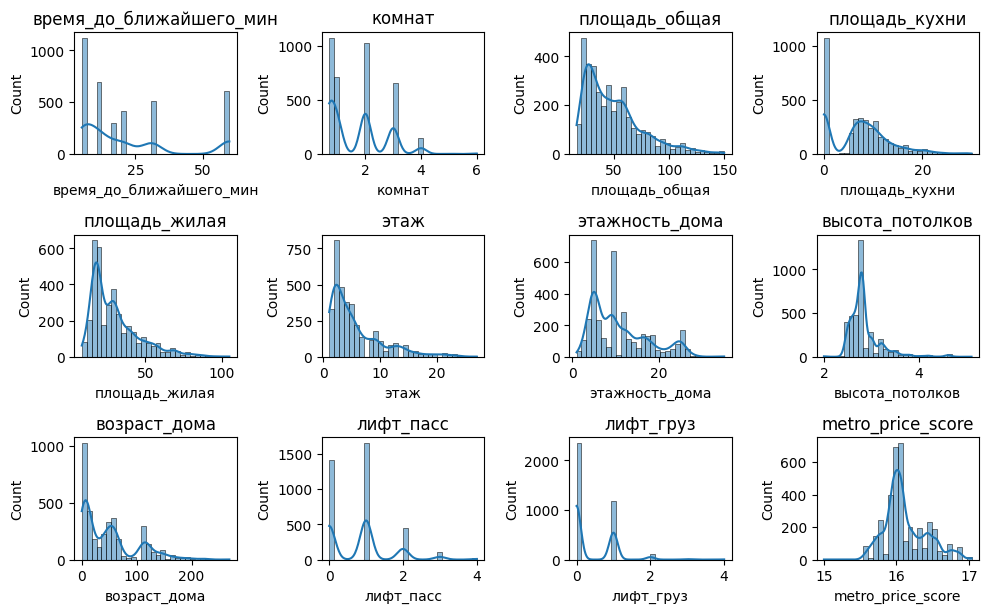

In [657]:
#смотрю влияние признаков на целевую переменную
fig = plt.figure(figsize=(10, 20))
for i, var_name in enumerate(num_features):
    ax = fig.add_subplot(10, 4, i+1)
    sns.histplot(df_train[var_name].dropna(), bins=30, kde=True)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()


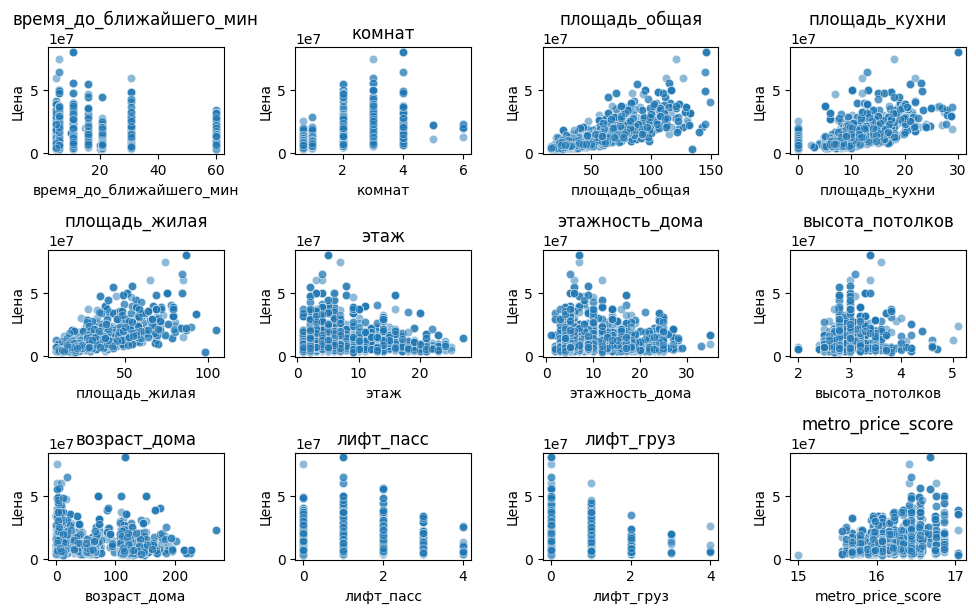

In [658]:
fig = plt.figure(figsize=(10, 20))
for i, var_name in enumerate(num_features):
    ax = fig.add_subplot(10, 4, i+1)
    sns.scatterplot(x=var_name, y="Цена", data=df_train, alpha=0.5)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [659]:
# Для train
cols_to_check_train = df_train.columns  # можно исключить 'Ссылка', если она есть
dupes_train = df_train[df_train.duplicated(subset=cols_to_check_train, keep=False)]
print("Train дубликаты:", len(dupes_train))
# Вывести
print(dupes_train)

# Удаляем дубликаты (оставляем первую встречу)
df_train = df_train.drop_duplicates(subset=cols_to_check_train, keep='first')

# Для test
cols_to_check_test = df_test.columns
dupes_test = df_test[df_test.duplicated(subset=cols_to_check_test, keep=False)]
print("Test дубликаты:", len(dupes_test))
# Вывести
print(dupes_test)

# Удаляем дубликаты
df_test = df_test.drop_duplicates(subset=cols_to_check_test, keep='first')


Train дубликаты: 2951
          Цена  время_до_ближайшего_мин  комнат  площадь_общая  площадь_кухни  \
798    7200000                      6.0     4.0           49.5            6.0   
5282   7000000                      6.0     0.7           24.3            0.0   
5231   6137300                     21.0     0.7           27.9            0.0   
2887  11000000                     31.0     2.0           57.6           16.1   
4511  12474735                     21.0     1.0           38.9            5.1   
...        ...                      ...     ...            ...            ...   
3772  36999000                      6.0     4.0          129.0           20.4   
5191   6137300                     21.0     0.7           27.9            0.0   
5226  25140000                     31.0     3.0           82.1           21.0   
5390  13900000                     60.0     2.0           58.7            9.0   
860    6999999                     16.0     2.0           45.6            6.7   

     

In [660]:
log_features = [
    "площадь_общая",
    "площадь_кухни",
    "площадь_жилая",
    "metro_price_score"
]
for col in log_features:
    df_train[col] = np.log1p(df_train[col])
    df_test[col] = np.log1p(df_test[col])

scale_features = [
    "время_до_ближайшего_мин",
    "комнат",
    "площадь_общая",
    "площадь_кухни",
    "площадь_жилая",
    "этаж",
    "этажность_дома",
    "высота_потолков",
    "возраст_дома",
    "metro_price_score",
]
scaler = StandardScaler()
df_train[scale_features] = scaler.fit_transform(df_train[scale_features])
df_test[scale_features] = scaler.transform(df_test[scale_features])

In [661]:
X_train = df_train.drop(columns=["Цена"])
y_train = df_train["Цена"]

X_test = df_test.drop(columns=["Цена"])
y_test = df_test["Цена"]

In [662]:
# Clip y если нужно
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

# One-Hot Encoding на объединенном датасете
combined = pd.concat([X_train, X_test])
combined_encoded = pd.get_dummies(combined, drop_first=True)

# Сохраняем количество строк
X_train = combined_encoded.iloc[:len(X_train), :]
X_test = combined_encoded.iloc[len(X_train):, :]

# Проверка размеров
print(X_train.shape, y_train.shape)  # должны совпадать
print(X_test.shape, y_test.shape)

(1545, 89) (1545,)
(728, 89) (728,)


In [663]:
# print(len(df_train), len(df_train.index.unique()))
# print(len(df_test), len(df_test.index.unique()))


In [664]:
X_train

,время_до_ближайшего_мин,комнат,площадь_общая,площадь_кухни,площадь_жилая,этаж,этажность_дома,высота_потолков,вид_сделки,лифт_пасс,...,доступность_метро_15_20мин,доступность_метро_20_30мин,доступность_метро_30_60мин,доступность_метро_далеко,комнаты_категория_1к,комнаты_категория_2к,комнаты_категория_3к,комнаты_категория_4к,комнаты_категория_5к+,комнаты_категория_особняк
798,-0.848841,2.368113,0.284392,0.218351,0.762461,-1.033612,-0.947451,-0.088807,1,0.0,...,False,False,False,False,False,False,False,True,False,False
5282,-0.848841,-1.002863,-1.211328,-1.578504,-0.798273,1.419744,1.145631,-0.088807,1,1.0,...,False,False,False,False,False,False,False,False,False,False
5231,-0.025818,-1.002863,-0.923430,-1.578504,0.154430,-0.829166,0.846619,-0.088807,0,1.0,...,False,True,False,False,False,False,False,False,False,False
26,-0.848841,1.346605,2.189633,1.145241,2.285913,0.193066,-0.648439,2.388961,0,0.0,...,False,False,False,False,False,False,True,False,False,False
2887,0.522864,0.325097,0.606319,1.043104,0.019773,0.601959,2.042666,-0.088807,0,2.0,...,False,False,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,2.114041,0.325097,1.202870,0.775656,0.324519,-0.420273,-1.096957,6.725056,1,1.0,...,False,False,True,False,False,True,False,False,False,False
4843,2.114041,1.346605,0.661015,0.364456,0.887470,-0.420273,-0.349428,-1.017970,1,1.0,...,False,False,True,False,False,False,True,False,False,False
1184,2.114041,-1.002863,-1.160606,-1.578504,-0.149863,2.033083,2.042666,-0.088807,1,2.0,...,False,False,True,False,False,False,False,False,False,False
130,-0.903709,-1.002863,-2.021404,-1.578504,-1.423926,-0.829166,-1.096957,1.150077,0,0.0,...,False,False,False,False,False,False,False,False,False,False


In [665]:
top10_features = [ #по влиянию на целевую переменную
    'площадь_общая',
    'площадь_кухни',
    'metro_price_score',
    'парковка_открытая_во_дворе',
    'время_до_ближайшего_мин',
    'возраст_дома',
    'площадь_жилая',
    'высота_потолков',
    'ремонт_косметический',
    'ремонт_требует ремонта'
]

# Создаем новые X_train и X_test только с этими признаками
X_train_top = X_train[top10_features]
X_test_top = X_test[top10_features]

In [666]:
MAX_PRICE = 100_000_000_000  

def rmse_pct_safe_real(y_true, y_pred, cap=100_000_000_000):
    y_pred = np.clip(y_pred, 0, cap)  # ограничение
    rmse_rub = np.sqrt(np.mean((y_true - y_pred)**2))
    rmse_pct = rmse_rub / y_true.mean() * 100
    return f"{rmse_rub:,.0f} руб, {rmse_pct:.2f}%"



In [667]:
# --- Dummy Regressor ---
dummy = DummyRegressor(strategy="median")
dummy.fit(X_train_top, y_train)
pred_dummy_train = dummy.predict(X_train_top)
pred_dummy_test = dummy.predict(X_test_top)
print("Dummy train RMSE руб:", rmse_pct_safe_real(np.clip(np.expm1(y_train), 0, MAX_PRICE), np.clip(np.expm1(pred_dummy_train), 0, MAX_PRICE)))
print("Dummy test RMSE руб:", rmse_pct_safe_real(np.clip(np.expm1(y_test), 0, MAX_PRICE), np.clip(np.expm1(pred_dummy_test), 0, MAX_PRICE)))


Dummy train RMSE руб: 8,517,351 руб, 74.66%
Dummy test RMSE руб: 9,814,063 руб, 82.76%


In [668]:
# --- Ridge ---
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_top, y_train)
pred_ridge_train = ridge.predict(X_train_top)
pred_ridge_test = ridge.predict(X_test_top)
print("Ridge train RMSE руб:", rmse_pct_safe_real(np.clip(np.expm1(y_train), 0, MAX_PRICE), np.clip(np.expm1(pred_ridge_train), 0, MAX_PRICE)))
print("Ridge test RMSE руб:", rmse_pct_safe_real(np.clip(np.expm1(y_test), 0, MAX_PRICE), np.clip(np.expm1(pred_ridge_test), 0, MAX_PRICE)))


Ridge train RMSE руб: 3,870,182 руб, 33.93%
Ridge test RMSE руб: 4,507,493 руб, 38.01%


In [669]:
# --- ElasticNet ---
enet = ElasticNet(alpha=0.01, l1_ratio=0.3, max_iter=5000)
enet.fit(X_train_top, y_train)
pred_enet_train = enet.predict(X_train_top)
pred_enet_test = enet.predict(X_test_top)
print("ElasticNet train RMSE руб:", rmse_pct_safe_real(np.clip(np.expm1(y_train), 0, MAX_PRICE), pred_enet_train))
print("ElasticNet test RMSE руб:", rmse_pct_safe_real(np.clip(np.expm1(y_test), 0, MAX_PRICE), pred_enet_test))


ElasticNet train RMSE руб: 14,013,817 руб, 122.85%
ElasticNet test RMSE руб: 15,105,536 руб, 127.39%


In [670]:
# --- RandomForest ---
rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=16,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_top, y_train)
pred_rf_train = rf.predict(X_train_top)
pred_rf_test = rf.predict(X_test_top)
print("RF train RMSE руб:", rmse_pct_safe_real(np.clip(np.expm1(y_train), 0, MAX_PRICE), pred_rf_train))
print("RF test RMSE руб:", rmse_pct_safe_real(np.clip(np.expm1(y_test), 0, MAX_PRICE), pred_rf_test))


RF train RMSE руб: 14,013,817 руб, 122.85%
RF test RMSE руб: 15,105,536 руб, 127.39%


In [671]:
y_train_clip = np.clip(np.expm1(y_train), 0, MAX_PRICE)
train_pool = Pool(X_train, y_train_clip)

In [672]:
# param_grid = {
#     'depth': [3,4,5],
#     'learning_rate': [0.03, 0.05, 0.1],
#     'l2_leaf_reg': [3,5,7],
#     'iterations': [300,400,5000]
# }

# best_rmse = float('inf')
# best_params = None

# for depth in param_grid['depth']:
#     for lr in param_grid['learning_rate']:
#         for l2 in param_grid['l2_leaf_reg']:
#             for iters in param_grid['iterations']:
#                 params = {
#                     'depth': depth,
#                     'learning_rate': lr,
#                     'l2_leaf_reg': l2,
#                     'iterations': iters,
#                     'loss_function': 'RMSE',
#                     'random_seed': 42,
#                     'verbose': 0
#                 }
#                 cv_results = cv(
#                     params=params,
#                     pool=train_pool,
#                     fold_count=3,
#                     early_stopping_rounds=50,
#                     verbose=False
#                 )
#                 mean_rmse = cv_results['test-RMSE-mean'].min()
#                 if mean_rmse < best_rmse:
#                     best_rmse = mean_rmse
#                     best_params = params

# print("Лучшие параметры:", best_params)
# print("Лучший CV RMSE:", best_rmse)

In [673]:
# CATBOOST_BEST_PARAMS = {
#     'depth': 5,
#     'learning_rate': 0.1,
#     'l2_leaf_reg': 3,
#     'iterations': 1000, #5000
#     'loss_function': 'RMSE',
#     'random_seed': 42,
#     'verbose': 0
# }

In [674]:
# # Финальное обучение на лучших параметрах
# cb_final = CatBoostRegressor(**CATBOOST_BEST_PARAMS)

# cb_final.fit(
#     X_train, 
#     y_train_clip, 
#     eval_set=(X_test, np.clip(np.expm1(y_test), 0, MAX_PRICE))
# )

# pred_train = cb_final.predict(X_train)
# pred_test = cb_final.predict(X_test)

# # RMSE и проценты
# print("CatBoost Train RMSE:", rmse_pct_safe_real(np.clip(np.expm1(y_train), 0, MAX_PRICE), pred_train))
# print("CatBoost Test RMSE:", rmse_pct_safe_real(np.clip(np.expm1(y_test), 0, MAX_PRICE), pred_test))

# y_train_clip = np.clip(np.expm1(y_train), 0, MAX_PRICE)
# train_pool = Pool(X_train_top, y_train_clip)

# cb_final = CatBoostRegressor(**CATBOOST_BEST_PARAMS)
# cb_final.fit(
#     X_train_top, 
#     y_train_clip, 
#     eval_set=(X_test_top, np.clip(np.expm1(y_test), 0, MAX_PRICE))
# )

# pred_train = cb_final.predict(X_train_top)
# pred_test = cb_final.predict(X_test_top)
# print("CatBoost Train RMSE:", rmse_pct_safe_real(np.clip(np.expm1(y_train), 0, MAX_PRICE), pred_train))
# print("CatBoost Test RMSE:", rmse_pct_safe_real(np.clip(np.expm1(y_test), 0, MAX_PRICE), pred_test))



In [675]:
# feat_imp = pd.Series(cb_final.get_feature_importance(), index=X_train.columns)
# feat_imp = feat_imp.sort_values(ascending=False)

# # Топ-10 признаков
# top10 = feat_imp.head(20)
# print(top10)

In [ ]:
# CATBOOST_SMALL_DATA_PARAMS = {
#     'iterations': 500,          # Меньше итераций
#     'depth': 5,                  # Меньше глубина (ключевое!)
#     'learning_rate': 0.03,       # Меньше темп обучения
#     'l2_leaf_reg': 10,           # Сильнее L2 регуляризация
#     'rsm': 0.8,                  # Subsample of features
#     'subsample': 0.7,            # Bagging temperature
#     'random_strength': 1.0,      # Регуляризация
#     'bootstrap_type': 'Bernoulli', # Для маленьких данных
#     # 'grow_policy': 'SymmetricTree', # УБИРАЕМ или меняем на 'Lossguide'
#     # 'max_leaves': 32,           # УБИРАЕМ - конфликт с SymmetricTree
#     'min_data_in_leaf': 10,      # Минимум в листе
#     'loss_function': 'RMSE',
#     'verbose': 100,
#     'early_stopping_rounds': 50, # Ранняя остановка ОБЯЗАТЕЛЬНО
#     'use_best_model': True
# }

In [ ]:
# cb_final = CatBoostRegressor(**CATBOOST_SMALL_DATA_PARAMS)

# cb_final.fit(
#     X_train, 
#     y_train_clip, 
#     eval_set=(X_test, np.clip(np.expm1(y_test), 0, MAX_PRICE))
# )

# pred_train = cb_final.predict(X_train)
# pred_test = cb_final.predict(X_test)

# # RMSE и проценты
# print("CatBoost Train RMSE:", rmse_pct_safe_real(np.clip(np.expm1(y_train), 0, MAX_PRICE), pred_train))
# print("CatBoost Test RMSE:", rmse_pct_safe_real(np.clip(np.expm1(y_test), 0, MAX_PRICE), pred_test))

0:	learn: 8000084.0239377	test: 9222759.0421887	best: 9222759.0421887 (0)	total: 1.64ms	remaining: 818ms
100:	learn: 3745197.5391042	test: 4675202.6859643	best: 4675202.6859643 (100)	total: 212ms	remaining: 839ms
200:	learn: 3166195.3141881	test: 4040910.0015523	best: 4040910.0015523 (200)	total: 324ms	remaining: 482ms
300:	learn: 2905987.9234920	test: 3764750.8911166	best: 3764750.8911166 (300)	total: 430ms	remaining: 284ms
400:	learn: 2685759.1784289	test: 3543079.7789613	best: 3543079.7789613 (400)	total: 525ms	remaining: 130ms
499:	learn: 2486521.9773236	test: 3344361.6251147	best: 3344361.6251147 (499)	total: 617ms	remaining: 0us

bestTest = 3344361.625
bestIteration = 499

CatBoost Train RMSE: 2,486,522 руб, 21.80%
CatBoost Test RMSE: 3,344,362 руб, 28.20%


In [690]:
from catboost import CatBoostRegressor

# Модель без use_best_model
cb_model = CatBoostRegressor(
    loss_function='RMSE',
    verbose=100,
    early_stopping_rounds=50,
    use_best_model=False
)

# Грид параметров
grid = {
    'depth': [4, 5, 6, 7],
    'learning_rate': [0.01, 0.03, 0.05],
    'l2_leaf_reg': [3, 5, 7, 10],
    'iterations': [500, 700],
    'rsm': [0.7, 0.8, 0.9],
    'subsample': [0.7, 0.8, 0.9],
    'random_strength': [1.0, 1.5]
}

# Грид-серч с разбиением train/test
grid_search_result = cb_model.grid_search(
    param_grid=grid,
    X=X_train,
    y=np.clip(np.expm1(y_train), 0, MAX_PRICE),
    search_by_train_test_split=True,
    train_size=0.8,
    plot=False,  # отключаем график
    shuffle=True
)


print("Лучшие параметры:", cb_model.get_params())


0:	learn: 13907672.5550940	test: 13872347.3497828	best: 13872347.3497828 (0)	total: 4.52ms	remaining: 2.25s
100:	learn: 7001531.7896892	test: 7370086.0965073	best: 7370086.0965073 (100)	total: 120ms	remaining: 475ms
200:	learn: 4601725.5971631	test: 5194885.9979932	best: 5194885.9979932 (200)	total: 212ms	remaining: 315ms
300:	learn: 3727733.9639592	test: 4420395.0671934	best: 4420395.0671934 (300)	total: 317ms	remaining: 210ms
400:	learn: 3342999.8444466	test: 4110065.2617647	best: 4110065.2617647 (400)	total: 416ms	remaining: 103ms
499:	learn: 3148071.9739291	test: 3980598.0481658	best: 3980598.0481658 (499)	total: 494ms	remaining: 0us

bestTest = 3980598.048
bestIteration = 499

0:	loss: 3980598.0481658	best: 3980598.0481658 (0)	total: 522ms	remaining: 15m 1s
0:	learn: 13679081.3125177	test: 13656900.7599845	best: 13656900.7599845 (0)	total: 2.02ms	remaining: 1.01s
100:	learn: 3717949.8141863	test: 4406698.9876108	best: 4406698.9876108 (100)	total: 167ms	remaining: 661ms
200:	learn:

In [691]:
best_params = grid_search_result['params']  # словарь с лучшими параметрами

# Создаем модель с этими параметрами
cb_best = CatBoostRegressor(
    **best_params,
    loss_function='RMSE',
    verbose=100,
    early_stopping_rounds=50,
    use_best_model=True
)

# Обучаем на тренировочном датасете
cb_best.fit(
    X_train, 
    np.clip(np.expm1(y_train), 0, MAX_PRICE),
    eval_set=(X_test, np.clip(np.expm1(y_test), 0, MAX_PRICE))
)

# Предсказания
pred_train = cb_best.predict(X_train)
pred_test = cb_best.predict(X_test)

# RMSE и проценты
print("Train RMSE:", rmse_pct_safe_real(np.clip(np.expm1(y_train), 0, MAX_PRICE), pred_train))
print("Test RMSE:", rmse_pct_safe_real(np.clip(np.expm1(y_test), 0, MAX_PRICE), pred_test))


0:	learn: 7913147.8930025	test: 9131899.7468842	best: 9131899.7468842 (0)	total: 956us	remaining: 669ms
100:	learn: 3097926.8717591	test: 3990578.7938561	best: 3990578.7938561 (100)	total: 90.4ms	remaining: 536ms
200:	learn: 2664333.7667352	test: 3563518.6507948	best: 3563518.6507948 (200)	total: 185ms	remaining: 460ms
300:	learn: 2240121.9592190	test: 3170546.4632207	best: 3170546.4632207 (300)	total: 279ms	remaining: 370ms
400:	learn: 1867812.6538807	test: 2864010.2750783	best: 2864010.2750783 (400)	total: 374ms	remaining: 279ms
500:	learn: 1610973.7498968	test: 2684332.1203803	best: 2684332.1203803 (500)	total: 469ms	remaining: 186ms
600:	learn: 1406542.6262037	test: 2561335.2873900	best: 2560940.0026550 (599)	total: 575ms	remaining: 94.7ms
699:	learn: 1247140.3474522	test: 2476675.5576083	best: 2476675.5576083 (699)	total: 701ms	remaining: 0us

bestTest = 2476675.558
bestIteration = 699

Train RMSE: 1,247,140 руб, 10.93%
Test RMSE: 2,476,676 руб, 20.89%
